In [1]:
from IPython.display import HTML

HTML('''<script>
$(document).ready(function() {
  
  all_cells = $('div.cell.border-box-sizing.code_cell.rendered')
  
  $.each(all_cells, function(idx, val){
      if ($(val).find('div.output_wrapper').length === 0){
        $(val).hide();
      }
    });
  });
  
</script>
''')

# <center> Sam The Cooking Guy Sentiment Analysis </center>

<center><img src="https://i.gyazo.com/e29f07756c858f39ce73daf2284d97ae.jpg" height=150 width=600></center>

## Objective

Sam the Cooking Guy is a cooking [YouTube channel](https://www.youtube.com/user/thesamlivecast) which I enjoy watching. Interested in doing some sentiment analysis, I decided I would analyze the comments section of some videos and see how positive/negative the responses are from users who comment.

### About The Data

All of the comment and video data was acquired by making requests to the YouTube Data API and then storing the data into a MS SQL Server database.

The database contains a simple schema with two tables related on the Video's ID as seen below:
<center><img src="https://i.gyazo.com/23e1efabedadb1400f9642481cf3e1fa.png" height=450 width=450></center>

All of the code for this project can be found at this [github repository](https://github.com/a-camarillo/samthecookingguy-sentiment-analysis). Check out some of my other work [here](https://a-camarillo.github.io/).

## Analysis

To begin the analysis, I will start with importing the libraries I'm going to use. I'm choosing to analyze just the burger videos from the database for right now so I also wrote a simple query to fetch the data for only those videos.

In [2]:
import pyodbc
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from os import path
from PIL import Image
import seaborn as sns

In [3]:
##connecting to database and querying data
server = 'DESKTOP-H5MDRS4\SQLEXPRESS'
database = 'youtube_db'
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; \
                      SERVER=' + server + ';  \
                      DATABASE=' + database +'; \
                      Trusted_Connection=yes;')
query = '''
        SELECT *
        FROM VideoComments c
        INNER JOIN VideoDetails d ON c.videoID = d.videoID
        WHERE d.category = 'Burger'
        '''
df = pd.read_sql(query,cnxn)
cnxn.close()

In [4]:
#drop duplicate videoID column
df = df.loc[:,~df.columns.duplicated()]

Taking a quick look at the data and looking at some high level descriptors.

In [5]:
df.head()

,videoID,commentAuthor,userID,comment,commentDateTime,commentTime,commentYear,commentMonth,commentDay,videoTitle,uploadDatetime,uploadTime,uploadYear,uploadMonth,uploadDay,category
0,Vm2R4GdhgsI,TW99,UCkIqKo00ZLweAcAfm3Wi9Fw,This video brings so much joy lol,2020-08-04 22:09:16,22:09:16,2020,8,4,20 POUND BACON CHEESEBURGER - 2 MILLION SUBSCR...,2020-07-01 16:18:35,16:18:35,2020,7,1,Burger
1,Vm2R4GdhgsI,Chris Williams,UC5YBqEXBQP-OrKW9YfXGj4g,Turn off the grill when you flop the patty lol...,2020-08-04 16:32:53,16:32:53,2020,8,4,20 POUND BACON CHEESEBURGER - 2 MILLION SUBSCR...,2020-07-01 16:18:35,16:18:35,2020,7,1,Burger
2,Vm2R4GdhgsI,Luchi Carp,UCEquXpCyHXmb8WCmrfKzFFA,Ta crudo pa,2020-08-04 04:37:29,04:37:29,2020,8,4,20 POUND BACON CHEESEBURGER - 2 MILLION SUBSCR...,2020-07-01 16:18:35,16:18:35,2020,7,1,Burger
3,Vm2R4GdhgsI,"Hi, I'm Barry Scott",UC0A3cJljgErijwGK5p6p-zA,Things I'd do differently: \n\n1. Used raw egg...,2020-08-03 23:34:21,23:34:21,2020,8,3,20 POUND BACON CHEESEBURGER - 2 MILLION SUBSCR...,2020-07-01 16:18:35,16:18:35,2020,7,1,Burger
4,Vm2R4GdhgsI,Bondi 420,UC3Km8LX5p-So7DZ_wVGlPrA,"""im gonna put all 5 lbs in here and squeeze it...",2020-08-03 21:24:59,21:24:59,2020,8,3,20 POUND BACON CHEESEBURGER - 2 MILLION SUBSCR...,2020-07-01 16:18:35,16:18:35,2020,7,1,Burger


In [6]:
print('Descriptors for Burger Videos')
print('Category:',df.category.unique())
print('Unique Videos:',df.videoID.nunique())
print('Total Comments:',len(df))
print('Unique Commentors:',df.userID.nunique())

Descriptors for Burger Videos
Category: ['Burger']
Unique Videos: 2
Total Comments: 5000
Unique Commentors: 4622


In [7]:
#define stop words
stop_words = set(stopwords.words('english'))

In [8]:
#first round of text cleaning
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub(r'https?:\/\/\S+','',text)
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'[“”"]+','',text)
    text = re.sub(r'[()]+','',text)
    text = re.sub(r'[$#@!?/*&.,:;]+',' ',text)
    text = text.rstrip()
    text = text.lower()
    return text

In [9]:
comments = pd.Series([clean_text(comment) for comment in df.comment])

In [10]:
#cleaning stop words
def comment_clean(comment):
    tokenize = word_tokenize(comment)
    clean_comment = ' '.join([word for word in tokenize if not word in stop_words])
    return clean_comment    

In [11]:
comments_cleaned = pd.Series([comment_clean(comment) for comment in comments])

In [12]:
#second round of text cleaning
def clean_text2(text):
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub(r'\bnt\b','',text)
    return text

In [13]:
comments_recleaned = pd.DataFrame(data=[clean_text2(comment) for comment in comments_cleaned],columns=['comments'])

In [14]:
#get subjectivity of comment
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#get polarity of comment
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [15]:
#label negative, neutral, and positivity of comments
def get_sentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [16]:
comments_recleaned['subjectivity'] = comments_recleaned['comments'].apply(get_subjectivity)
comments_recleaned['polarity'] = comments_recleaned['comments'].apply(get_polarity)
comments_recleaned['sentiment'] = comments_recleaned['polarity'].apply(get_sentiment)

In [17]:
total_words = ' '.join([words for words in comments_recleaned['comments']])

In [18]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
sam_mask = np.array(np.array(Image.open(path.join(d, "C:/Users/antho/Pictures/samcookingguy.jpg"))))

In [19]:
wordCloud = WordCloud(width=700,height=700, random_state=21,max_font_size=120,mask=sam_mask,background_color="white").generate(total_words)

### Word Cloud

After some text cleaning, I created a word cloud to represent the most common words among the comments. It looks like some of the most common words are burger, sam, and video which aren't too surprising since these are most relevant to the videos. 

There are some other words that do stand out which could be a good indicator toward more positive sentiment, for example: love, good, and awesome.

(-0.5, 959.5, 639.5, -0.5)

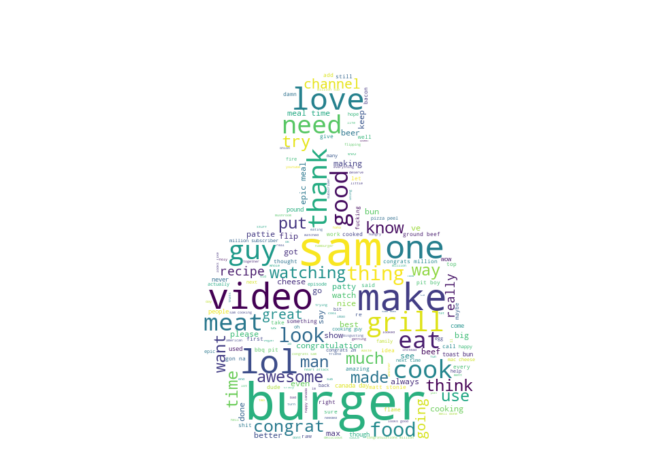

In [20]:
plt.figure(figsize=(12,8))
plt.imshow(wordCloud,interpolation="bilinear")
plt.axis("off")

In [21]:
comments_recleaned[['video_id','user_id','comment_dt','upload_dt']] = df[['videoID','userID','commentDateTime','uploadDatetime']]

In [22]:
twenty_burger = comments_recleaned[comments_recleaned['video_id']=='Vm2R4GdhgsI']
beer_burger = comments_recleaned[comments_recleaned['video_id']=='xdBi-CbLlx4']

### Comparing Polarity

The library, textblob, provides polarity for text on a scale from -1.0 to 1.0. Polarity is the sentiment measurement of a statement with -1 being most negative in connation, 1 being most positive in connotation, and 0 being a neutral statement.

I was interested in seeing how the sentiment varies between the two videos. The two count plots show both videos have comments which are generally positive or neutral, although the 20 LB Burger video has a much higher comment count. 

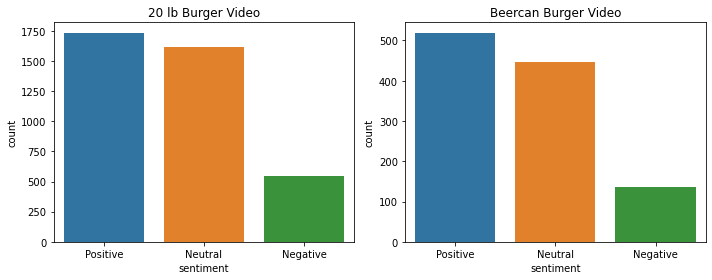

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.countplot(twenty_burger['sentiment'],order=['Positive','Neutral','Negative'])
plt.title('20 lb Burger Video')
plt.subplot(122)
sns.countplot(beer_burger['sentiment'],order=['Positive','Neutral','Negative'])
plt.title('Beercan Burger Video')
plt.tight_layout()

In [24]:
twenty_sorted = twenty_burger.sort_values(by='comment_dt')
beercan_sorted = beer_burger.sort_values(by='comment_dt')

In [25]:
tgrouped = twenty_sorted.groupby([twenty_sorted.comment_dt.dt.date,twenty_sorted.comment_dt.dt.hour]).mean().reset_index(level=1).rename(columns={'comment_dt':'hour'}).reset_index().rename(columns={'comment_dt':'date'})
tgrouped['grouped_dt'] = pd.to_datetime(tgrouped['date'].map(str)+' '+tgrouped['hour'].map(str)+':00',format='%Y-%m-%d %H:%M')

In [26]:
bgrouped = beercan_sorted.groupby([beercan_sorted.comment_dt.dt.date,beercan_sorted.comment_dt.dt.hour]).mean().reset_index(level=1).rename(columns={'comment_dt':'hour'}).reset_index().rename(columns={'comment_dt':'date'})
bgrouped['grouped_dt'] = pd.to_datetime(bgrouped['date'].map(str)+' '+bgrouped['hour'].map(str)+':00',format='%Y-%m-%d %H:%M')

After looking at the sentiment counts, I was curious to see how each video's sentiment varied over time. To observe this change over time, I grouped the polarity of the comments by day and hour they were posted and then took the average of the grouped polarities.

The average polarity of comments for both videos is largely positive although each video has their spikes of negativity. In addition, the frequency of comments is much higher for the 20 LB Burger video than the Beer Can Burger video but this can also be due to the 20 LB Burger video being uploaded longer.

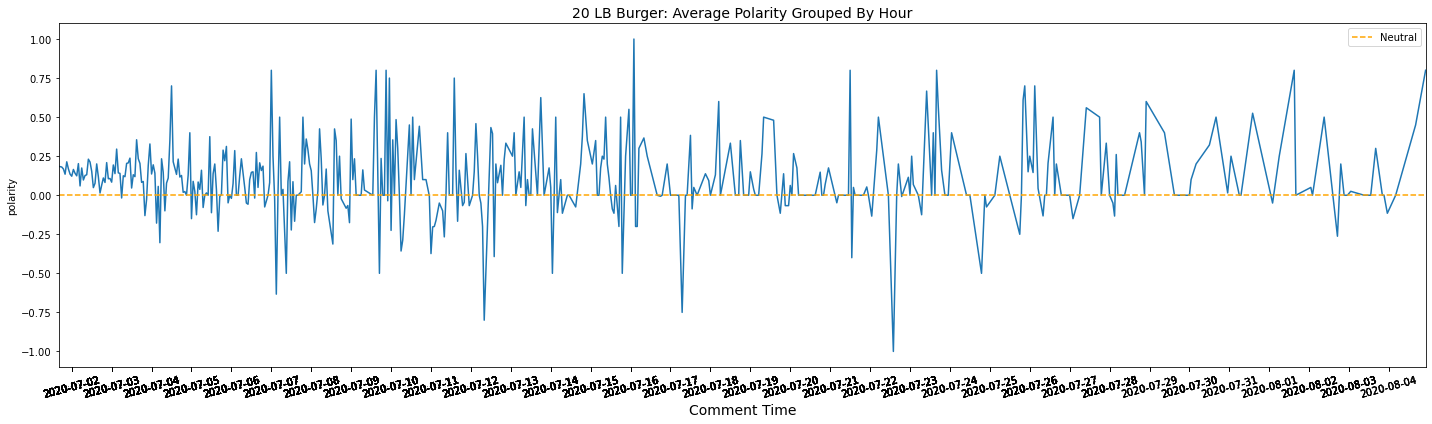

In [27]:
plt.figure(figsize=(20,6))
sns.lineplot(x='grouped_dt',y='polarity',data=tgrouped)
plt.xticks(ticks=tgrouped['date'],rotation=15)
plt.xlim(twenty_sorted['upload_dt'].min(),tgrouped['grouped_dt'].max())
plt.xlabel('Comment Time',fontsize=14)
plt.axhline(y=0,color='orange',linestyle='dashed',label='Neutral')
plt.title('20 LB Burger: Average Polarity Grouped By Hour',fontsize=14)
plt.legend()
plt.tight_layout()

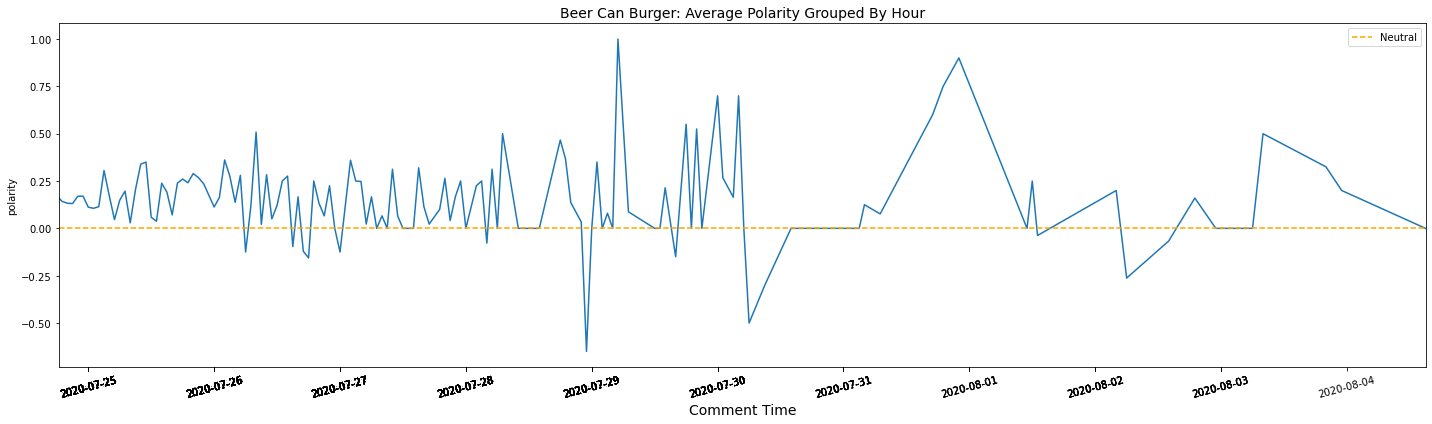

In [28]:
plt.figure(figsize=(20,6))
sns.lineplot(x='grouped_dt',y='polarity',data=bgrouped)
plt.xticks(ticks=bgrouped['date'],rotation=15)
plt.xlim(beercan_sorted['upload_dt'].min(),bgrouped['grouped_dt'].max())
plt.xlabel('Comment Time',fontsize=14)
plt.title('Beer Can Burger: Average Polarity Grouped By Hour',fontsize=14)
plt.axhline(y=0,color='orange',linestyle='dashed',label='Neutral')
plt.legend()
plt.tight_layout()

### Comparing Subjectivity

Textblob also provides subjectivity for text on a scale from 0.0 to 1.0, where 0 is a factual statement and 1 is a statement based on opinion and emotion.

This might not give too much insight for youtube comments since I suspect most comments are made with subjectivity, for example: "I liked/disliked the video" or "the burger looks good/bad". Still I am interested in looking at how subjective the comments are.

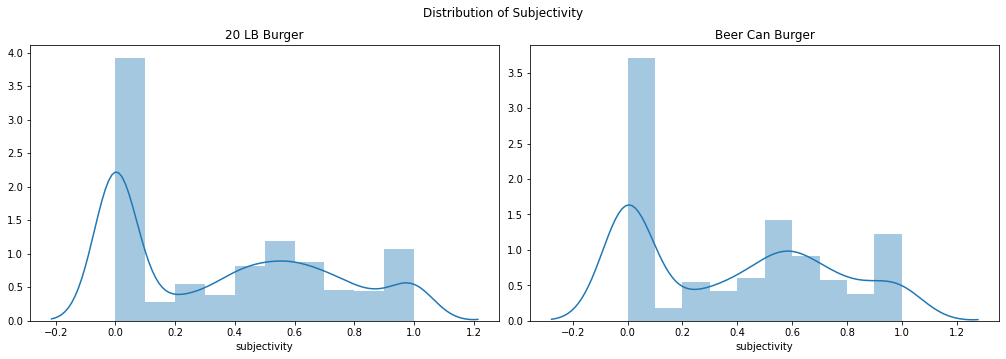

In [29]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.suptitle('Distribution of Subjectivity')
sns.distplot(twenty_sorted.subjectivity,bins=10)
plt.title('20 LB Burger')
plt.subplot(122)
sns.distplot(beercan_sorted.subjectivity,bins=10)
plt.title('Beer Can Burger')
plt.tight_layout(pad=0.8)

Much to my surprise, the distributions show a large amount of comments to be in the objective-lower subjective range.

After a little more investigating, 41% of the comments for the 20 LB Burger video are between 0 and 0.1 subjectivity while 38% of the comments for the Beer Can Burger are between 0 and 0.1 subjectivity. Although both of the videos' comments are majority subjective, the percentages of low subjectivity are much higher than my initial expectations.

In [30]:
twpct = len(twenty_sorted[twenty_sorted.subjectivity <= 0.1])/len(twenty_sorted)
bcpct = len(beercan_sorted[beercan_sorted.subjectivity <= 0.1])/len(beercan_sorted)
print(f'Percentage of Objective/Low Subjectivity Comments for 20 LB Burger: {twpct*100:.0f}%')
print(f'Percentage of Objective/Low Subjectivity Comments for Beer Can Burger: {bcpct*100:.0f}%')

Percentage of Objective/Low Subjectivity Comments for 20 LB Burger: 41%
Percentage of Objective/Low Subjectivity Comments for Beer Can Burger: 38%


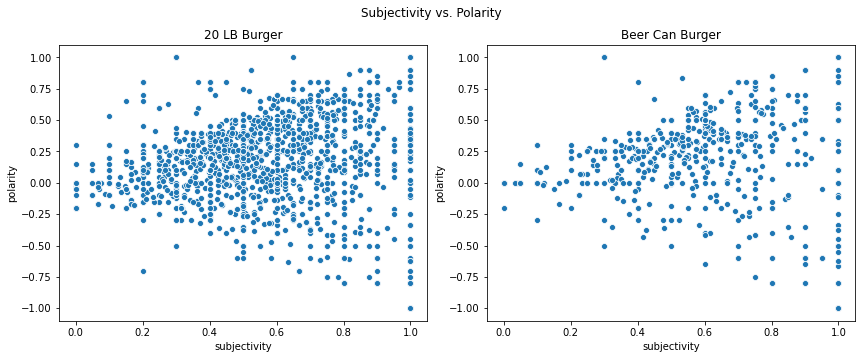

In [31]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.suptitle('Subjectivity vs. Polarity')
sns.scatterplot(x=twenty_sorted.subjectivity,y=twenty_sorted.polarity)
plt.title('20 LB Burger')
plt.subplot(122)
sns.scatterplot(x=beercan_sorted.subjectivity,y=beercan_sorted.polarity)
plt.title('Beer Can Burger')
plt.tight_layout(pad=0.8)

For both videos, subjectivity versus polarity is as expected. As subjectivity for the text increases, polarity moves further away from the neutral point. This makes sense since a comment which is perceived as more positive or negative is more likely to have language conveying emotion/opinion.

### Repeat Commentors

One last point of interest for me is to look at users who have multiple comments and observe the sentiment of these users.

First I wanted to look at the actual number of users with multiple comments.

In [32]:
comments_recleaned['video_title'] = df['videoTitle']
total_commentors = comments_recleaned.user_id.nunique()

In [33]:
comments_ordered = comments_recleaned[comments_recleaned.user_id.duplicated(keep=False)].groupby(['video_title','user_id']).count().sort_values(by='comments',ascending=False).reset_index()
multi_commentors = comments_ordered.user_id.nunique()

In [34]:
twenty_commentors=list(comments_ordered[comments_ordered.video_title=='20 POUND BACON CHEESEBURGER - 2 MILLION SUBSCRIBER SPECIAL | SAM THE COOKING GUY 4K'].user_id)
beercan_commentors=list(comments_ordered[comments_ordered.video_title=='THE BEST BEER CAN (STUFFED) BURGERS | SAM THE COOKING GUY 4K'].user_id)

In [35]:
comment_twenty = comments_recleaned[comments_recleaned.user_id.isin(twenty_commentors) & ~comments_recleaned.user_id.isin(beercan_commentors)]
comment_beercan = comments_recleaned[comments_recleaned.user_id.isin(beercan_commentors) & ~comments_recleaned.user_id.isin(twenty_commentors)]
comment_both = comments_recleaned[comments_recleaned.user_id.isin(beercan_commentors) & comments_recleaned.user_id.isin(twenty_commentors)]
both_commentors = comment_both.user_id.nunique()

In [36]:
print(f'Total number of individuals who commented: {total_commentors}\nIndividuals who made multiple comments: {multi_commentors}\nIndividuals who commented on both videos: {both_commentors}')

Total number of individuals who commented: 4622
Individuals who made multiple comments: 307
Individuals who commented on both videos: 141


Of the total individuals who posted a comment, only about 6.6% actually made more than one comment. However, of the users who made multiple comments, about 46% chose to comment on both videos. 

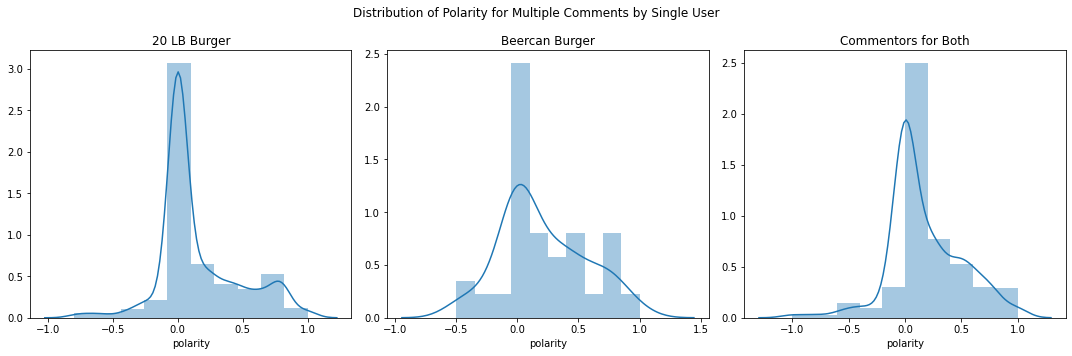

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.suptitle('Distribution of Polarity for Multiple Comments by Single User')
sns.distplot(comment_twenty['polarity'],bins=10)
plt.title('20 LB Burger')
plt.subplot(132)
sns.distplot(comment_beercan['polarity'],bins=10)
plt.title('Beercan Burger')
plt.subplot(133)
sns.distplot(comment_both['polarity'],bins=10)
plt.title('Commentors for Both')
plt.tight_layout()

The distributions of polarity among the repeat commentors are all pretty similar with a large amount of comments hovering around neutral to low positivity.

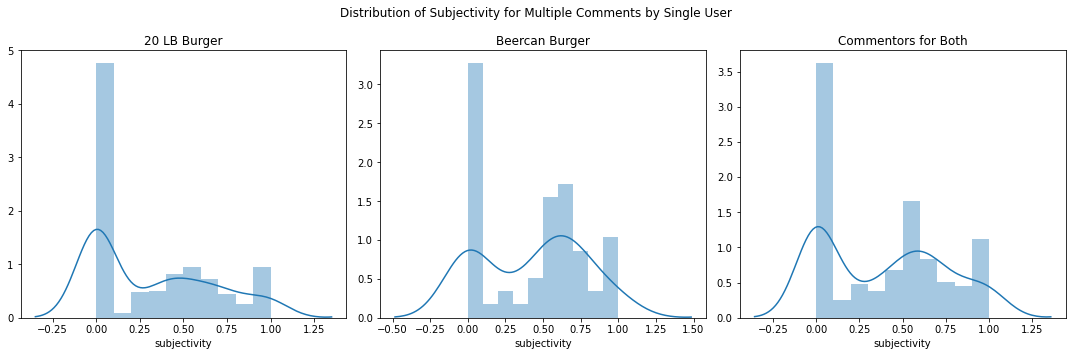

In [38]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.suptitle('Distribution of Subjectivity for Multiple Comments by Single User')
sns.distplot(comment_twenty['subjectivity'],bins=10)
plt.title('20 LB Burger')
plt.subplot(132)
sns.distplot(comment_beercan['subjectivity'],bins=10)
plt.title('Beercan Burger')
plt.subplot(133)
sns.distplot(comment_both['subjectivity'],bins=10)
plt.title('Commentors for Both')
plt.tight_layout()

The distributions of subjectivity are also similar, it appears a lot of comments are low in subjectivity. This would make sense since the earlier plot of Subjectivity vs. Polarity revealed text closer to 0 in subjectivity tends to be closer to neutral in polarity. 

Finally, to look at the average polarity of the users who did post multiple comments.

In [39]:
ctg = comment_twenty.groupby([comment_twenty.comment_dt.dt.date,comment_twenty.comment_dt.dt.hour]).mean().reset_index(level=1).rename(columns={'comment_dt':'hour'}).reset_index().rename(columns={'comment_dt':'date'})
ctg['grouped_dt'] = pd.to_datetime(ctg['date'].map(str)+' '+ctg['hour'].map(str)+':00',format='%Y-%m-%d %H:%M')
cbeg = comment_beercan.groupby([comment_beercan.comment_dt.dt.date,comment_beercan.comment_dt.dt.hour]).mean().reset_index(level=1).rename(columns={'comment_dt':'hour'}).reset_index().rename(columns={'comment_dt':'date'})
cbeg['grouped_dt'] = pd.to_datetime(cbeg['date'].map(str)+' '+cbeg['hour'].map(str)+':00',format='%Y-%m-%d %H:%M')
cbg = comment_both.groupby([comment_both.comment_dt.dt.date,comment_both.comment_dt.dt.hour]).mean().reset_index(level=1).rename(columns={'comment_dt':'hour'}).reset_index().rename(columns={'comment_dt':'date'})
cbg['grouped_dt'] = pd.to_datetime(cbg['date'].map(str)+' '+cbg['hour'].map(str)+':00',format='%Y-%m-%d %H:%M')

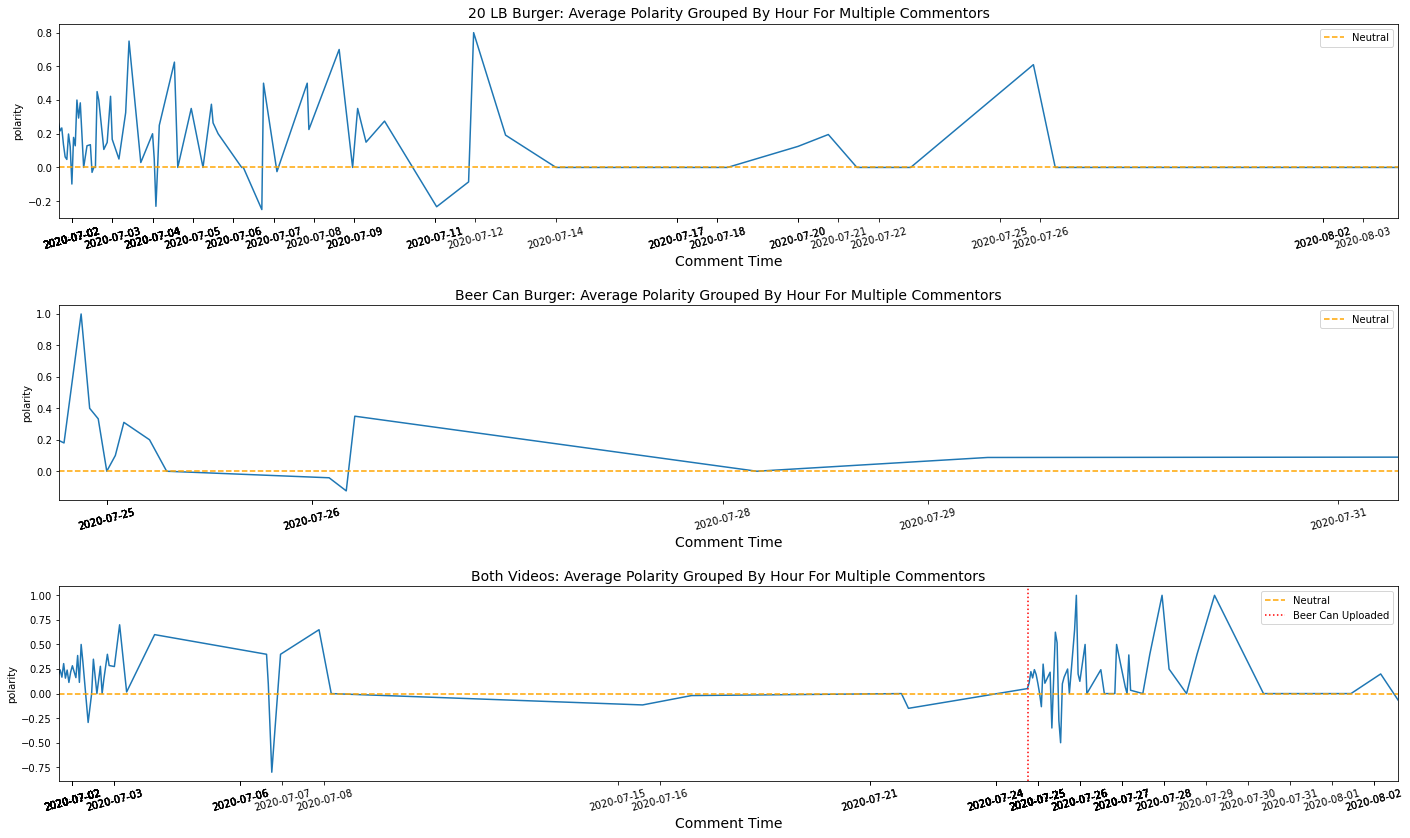

In [40]:
plt.figure(figsize=(20,12))
plt.subplot(311)
sns.lineplot(x='grouped_dt',y='polarity',data=ctg)
plt.xticks(ticks=ctg['date'],rotation=15)
plt.xlim(comment_twenty['upload_dt'].min(),ctg['grouped_dt'].max())
plt.xlabel('Comment Time',fontsize=14)
plt.title('20 LB Burger: Average Polarity Grouped By Hour For Multiple Commentors',fontsize=14)
plt.axhline(y=0,color='orange',linestyle='dashed',label='Neutral')
plt.legend()
plt.subplot(312)
sns.lineplot(x='grouped_dt',y='polarity',data=cbeg)
plt.xticks(ticks=cbeg['date'],rotation=15)
plt.xlim(comment_beercan['upload_dt'].min(),cbeg['grouped_dt'].max())
plt.xlabel('Comment Time',fontsize=14)
plt.title('Beer Can Burger: Average Polarity Grouped By Hour For Multiple Commentors',fontsize=14)
plt.axhline(y=0,color='orange',linestyle='dashed',label='Neutral')
plt.legend()
plt.subplot(313)
sns.lineplot(x='grouped_dt',y='polarity',data=cbg)
plt.xticks(ticks=cbg['date'],rotation=15)
plt.xlim(comment_twenty['upload_dt'].min(),cbg['grouped_dt'].max())
plt.xlabel('Comment Time',fontsize=14)
plt.title('Both Videos: Average Polarity Grouped By Hour For Multiple Commentors',fontsize=14)
plt.axhline(y=0,color='orange',linestyle='dashed',label='Neutral')
plt.axvline(x=comment_beercan['upload_dt'].min(),color='red',linestyle='dotted',label='Beer Can Uploaded')
plt.legend()
plt.tight_layout(pad=2)

It appears average polarity of repeat commentors is similar to the overall commenting, generally positive with some small spikes of negativity. 

One interesting thing to note is the frequency of commenting for users who commented on both videos. There is a lot of activity going on from these users shortly after each video is uploaded. This could indicate that users who comment on multiple videos are also likely to watch them shortly after their upload. 

## Conclusion

Overall the sentiment of users who commented on these videos is generally positive which means that it's likely the users who chose to comment wanted to express their enjoyment of the video or the food that was made.

In the future, I can collect comments for more burger videos to see if the sentiment changes with more comments to analyze. I can also query other categories, such as chicken, to compare the sentiment by categories.